# **Paper Information**

**Paper Title:** STGAN: A Unified Selective Transfer Network
for Arbitrary Image Attribute Editing [https://arxiv.org/pdf/1904.09709.pdf](https://arxiv.org/pdf/1904.09709.pdf)

**Paper Authors:** Ming Liu, Yukang Ding, Min Xia, Xiao Liu, Errui Ding, Wangmeng Zuo, Shilei Wen

**Project Group Members:** Ali İlker Sığırcı, İlyas Eren Yılmaz

**Contact Information:** e217194@metu.edu.tr, e217220@metu.edu.tr


## **Paper Summary**

### **Introduction**

![1](notebook_images/1.png)

In image attribute editing, the goal is to manipulate an image
with desired attributes but this is a hard problem. Since there isn't enough paired images with/without these attributes, we can only use models such as encoder-decoder and GANs. 

Unfortunately, using encoder-decoder architecture for multi-domain image-to-image translation tasks has limited success. The problem here is that the latent layer becomes a restriction and this results in low quality, blurry images. Researches introduces skip connection to get high quality images but this reduces the freedom of attribute manipulation. 

Moreover, some existings methods like STARGAN takes image and its corresponding full attribute vector as a input. Later, we will discuss that this is actually not a good approach.  

To address the above issues, the authors introduce STGAN model.
The model has two important features that are different from different from the rest:
* Taking attribute difference vector as input
* Transfer encoder output to decoder with Selective Transfer Unit(STU)

![2](notebook_images/2.png)

Thanks to these important features, they able to fully reconstruct the original image. Morever as you see from the above figure, STGAN model can better edit the attributes than the state-of-the-art models.

In the paper, CelebA dataset is used which contains 40 different attributes. Among them, the authors choose 13 attributes. The reason is that this attributes result in better distintive view.
The attributes are:
* Bald, Black Hair, Blond Hair, Brown Hair
* Bangs, Eyebrows, Eyeglasses, Gender, Mouth Open, Mustache, No Beard,Pale Skin, Age

## Architecture

### General Structure

![3](notebook_images/3.png)

The model is consist of two components,a generator G and a discriminator D.
The generator G has an encoder G_enc for abstract latent representation, a decoder G_dec for target image generation, and G_st consists of a series of selective transfer units
(STUs) for selective feature transfer.

The discriminator D has two branches D_adv and D_att.
D_adv decides whether an image is fake or not and D_att predicts an attribute vector.

Moreover, as can be seen in the figure, generator has:
* 5 encoder layers with kernel size as 4 and stride as 1.
* 4 STU shortcut layers for transfering encoder features.
* 5 decoder layers with kernel size as 4 and stride as 2.

#### Introducing Attribute Difference

Existing methods such as StarGAN or AttGAN take whole attribute vector as a input to the model.

The authors discuss that taking attribute difference as input gives better result.
For example, if we want to remove smile effect from the picture, we just change its correspending attribute and feed only this vector to the model rather than the whole attribute vector.

With this way, the authors show that, they get near perfect reconstruction since there is no attribute difference between source and target image attributes. Moreover, this method makes the attribute editing more intuitive since the user of the model doesn't need to know about the whole attribute vector. Instead s/he just need to know what attribute s/he would like to change. This approach makes the interactive editing more robust and easy to use. 

#### STU Structure

![4](notebook_images/4.png)

The authors introduce Selective Transfer Units to transder encoder features to the decoder.
Existing methods only concatanes encoder output to decoder and it is called the skip connection.
But in here, it is more like a calculated shortcut layer.

The authors took the structure of GRU as a base and modify it. The structure and its corresponding formulation can be seen in the figure.

## LOSS
The input of the generator and output of the generator is generalized as following in order to simplify the formulas

![5](notebook_images/5.png)

### Reconstruction Loss

Reconstruction loss calculated for generator by giving input images and attribute difference vector as zero. Since the difference is zero generator must generate the same image as output. The L1 norm between input and output is the resulting reconstruction loss.

![6](notebook_images/6.png)

### Adverserial Losses

Adverserial losses of discriminator consists of two main parts. The first part of the equation is the general GAN loss for discriminator. The second part is the gradient penalty. Gradient penalty is calculated by taking a sample along lines between pairs of real and generated images which is called x hat and calculating the gradient of output of discriminator given x hat as input. The output gradients are then put into l2 norm. Final product is generally multiplied with gradient penalty constant lambda.

Adverserial loss of generator is the same as GAN adverserial losses for generators. The generated fake images are passed to discriminator and then resulting values are optimized.

![7](notebook_images/7.png)


### Attribute Manipulation Losses

These losses are used to check whether the target attribute requirements are met for generator and whether dicriminator can detect attributes correctly.

![8](notebook_images/8.png)

### Model Objective

Following structures are the total loss functions for generator and discriminator. In the paper and our implementations model tradeoff parameters lambda values are taken as 1,10 and 100 respectively.

![9](notebook_images/9.png)
![10](notebook_images/10.png)

# Global Imports

In [1]:
import os
import torch
import matplotlib.pyplot as plt
%matplotlib inline 

from resources import *

%load_ext autoreload
%autoreload 2

In [2]:
from platform import python_version

print(python_version())
print(torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

3.8.8
1.8.1
cuda


In [3]:
!nvidia-smi

Tue Jul  6 23:33:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.80       Driver Version: 460.80       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1650    Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P0    17W /  N/A |      7MiB /  3911MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Global Parameters

In [15]:
learning_rate = 0.0002 # Learning Rate of Discriminator and Generator given to optimizer Adam
encoding_dim = 64 # Encoding dimension of Discriminator and Generator
crop_size = 150 # center crop image size when loading the data
image_size = 64 # Size of images expected by models
attribute_dim = 13 # Number of attributes
fc_dim = 1024 # Dimension of full connected layers
num_epochs = 1 # total epoch number
decay_epoch = 1 # For  learning rate 
batch_size = 32
beta1 = 0.5
beta2 = 0.999
lamb = 10
lamb1 = 1
lamb2 = 10
lamb3 = 100

set_seeds(796)

# DATASET

## Download Dataset (CELEBA)

Instead of download_data.sh script, use this cell instead (optional)

Downloading a large file from google drive is a bit tricky. So we provide 
this cell to make it more intuitive.

NOTE: Data size is about 1.5G


In [5]:
# Download And Extract Data

import gdown
import os

data_root = 'data'
data_file_name = "ceng796_project_data.tar.xz"
data_url = "https://drive.google.com/uc?id=1-QLU_-u5RErsMppPq6d74waBLnreehAM"

if not os.path.exists(data_root):
    gdown.download(data_url, data_file_name, quiet=True)
    !tar -xzf ceng796_project_data.tar.xz
    !rm -rf ceng796_project_data.tar.xz

## Load Dataset

In [13]:
## Import CelebA Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
data_root = 'data'

transforms = transforms.Compose([
    transforms.CenterCrop(crop_size),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
])

celeba_train_data = datasets.CelebA(data_root,
                              download=False,
                              split='train',
                              transform=transforms)

celeba_valid_data = datasets.CelebA(data_root,
                              download=False,
                              split='valid',
                              transform=transforms)

celeba_test_data = datasets.CelebA(data_root,
                              download=False,
                              split='test',
                              transform=transforms)

# Dataloader is used to shuffle the corresponding sets and create separate batches of data
# Every batch consists of two tensors. First tensor holds the input images and second tensor holds the attributes of the images respectively
train_loader = DataLoader(celeba_train_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(celeba_valid_data, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(celeba_test_data,  batch_size=batch_size, shuffle=False)

print(celeba_train_data)
print(celeba_valid_data)
print(celeba_test_data)

Dataset CelebA
    Number of datapoints: 162770
    Root location: data
    Target type: ['attr']
    Split: train
    StandardTransform
Transform: Compose(
               CenterCrop(size=(150, 150))
               Resize(size=64, interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
Dataset CelebA
    Number of datapoints: 19867
    Root location: data
    Target type: ['attr']
    Split: valid
    StandardTransform
Transform: Compose(
               CenterCrop(size=(150, 150))
               Resize(size=64, interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
Dataset CelebA
    Number of datapoints: 19962
    Root location: data
    Target type: ['attr']
    Split: test
    StandardTransform
Transform: Compose(
               CenterCrop(size=(150, 150))
               Resize(size=64, interpolation=bilinear)
               ToTensor(

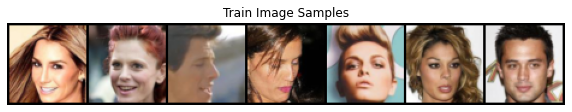

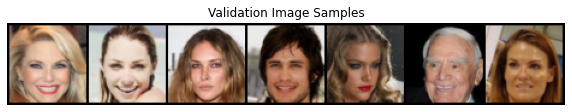

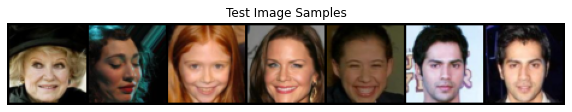

In [14]:
# Showing images of real examples from CelebA

images_train = next(iter(train_loader))[0]
images_valid = next(iter(valid_loader))[0]
images_test = next(iter(test_loader))[0]

show_images(images_train, title="Train Image Samples")
show_images(images_valid, title="Validation Image Samples")
show_images(images_test, title="Test Image Samples")

# TRAINING

We have used colab notebook for training with Tesla T4. We have also tested the model with GTX 1650 on our local machine. In both cases, for batch_size=64, it took approximately 2 hours for one epoch. Although we couldn't achieve our goals, we trained the model almost 6 hours.

In [9]:
# For saving intermediate outputs
if not os.path.exists("images"):
    !mkdir "images"

In [16]:
#Training section 
from tqdm.notebook import tqdm
import gc
import torch
import torch.optim as optim

gc.collect()
torch.cuda.empty_cache()

# Generator Model is instantiated
gen = Generator(encoding_dim, attribute_dim)
gen = gen.to(device)  

# Discriminator Model is instantiated
disc = Discriminator(image_size, encoding_dim, fc_dim, attribute_dim) 
disc = disc.to(device)  

# Adam is used as the optimizer with the parameters and betas given by the STGAN paper
optim_disc = torch.optim.Adam(disc.parameters(), lr=learning_rate, betas=[beta1, beta2])
optim_gen = torch.optim.Adam(gen.parameters(), lr=learning_rate, betas=[beta1, beta2])

# Scheduler is used for adaptive learning late in both optimizer of generator and discriminator
scheduler_disc = optim.lr_scheduler.StepLR(optim_disc, step_size=decay_epoch, gamma=0.1)
scheduler_gen = optim.lr_scheduler.StepLR(optim_gen, step_size=decay_epoch, gamma=0.1)

model_progress = []
disc_training_loss = []
gen_training_loss = []
disc_loss_per_batch = []
gen_loss_per_batch = []

attr_class = Attribute(device)

for epoch in range(1, num_epochs+1):

    disc_running_loss = 0.0
    gen_running_loss  = 0.0

    val_iter = iter(valid_loader)
    x_val, attr_val = next(val_iter)
    
    attr_val = attr_val.float()
    attr_val = attr_class.select_important_attributes(attr_val)
    val_attrs_list = attr_class.create_attr_list(attr_val)

    for index, (org_images, org_attrs) in tqdm(enumerate(train_loader)):

        gen.train()
        disc.train()

        org_attrs = org_attrs.float()
        org_images = org_images.to(device)
        org_attrs = attr_class.select_important_attributes(org_attrs)

        # randomly shuffle original attributes to generate target attributes
        random_indices = torch.randperm(org_attrs.shape[0])
        target_attrs = org_attrs[random_indices]
        
        org_attrs = org_attrs.to(device)

        target_attrs = target_attrs.to(device)

        # Discriminator Training and Loss
        discr_loss = discr_model_obj(disc, gen, org_images, org_attrs, target_attrs, lamb, lamb1, device)

        disc_loss_per_batch.append(discr_loss)
        disc_running_loss += discr_loss.item()

        optim_disc.zero_grad()
        discr_loss.backward()
        optim_disc.step()
        
        # For testing resconstruction
        # gen_loss = reconst_loss(gen, org_images, device)

        gen_loss = gen_model_obj(disc, gen, org_images, org_attrs, target_attrs, lamb2, lamb3, device)
        gen_loss_per_batch.append(gen_loss)
        gen_running_loss += gen_loss.item()

        optim_gen.zero_grad()
        gen_loss.backward()
        optim_gen.step()

        scheduler_disc.step()
        scheduler_gen.step()

        # Test Trained Generator on Validation Images
        if index % 20 == 0:
            # save_state(gen, optim_gen, index, "gen_test", path="./")
            # save_state(disc, optim_disc, index, "discr_test", path="./")

            print("discr_loss", discr_loss.item())
            print("gen_loss", gen_loss.item())

            image_path = f'images/img_{index}.jpg'

            gen.eval()

            with torch.no_grad():
            
                generated_validation_images = generate_image_samples(x_val, gen, val_attrs_list, device=device)
                save_images(generated_validation_images, image_path, sample_size=10)
        
        if index == 100:
            break
                
    # disc_running_loss /= len(train_loader.dataset)
    # gen_running_loss /= len(train_loader.dataset)
    # disc_training_loss.append(disc_running_loss)
    # gen_training_loss.append(gen_running_loss)


0it [00:00, ?it/s]

discr_loss 7.6630024909973145
gen_loss 135.79898071289062
discr_loss 0.10404634475708008
gen_loss 123.78727722167969
discr_loss 2.281871795654297
gen_loss 122.87301635742188
discr_loss 0.9711360931396484
gen_loss 122.0372314453125
discr_loss 0.0822601318359375
gen_loss 123.72135925292969
discr_loss -1.4958395957946777
gen_loss 120.70519256591797


In [ ]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
# plt.title(title)
plt.xlabel("Iteration")
plt.ylabel("Generator Loss")
plt.plot(gen_loss_per_batch.cpu())
plt.subplot(1, 2, 2)
# plt.title(title)
plt.xlabel("Iteration")
plt.ylabel("Discriminator Loss")
plt.plot(disc_loss_per_batch.cpu())

## Intermediate Training Results

### Iteration 0

![11](notebook_images/img_0.jpg)

### Iteration 60

![12](notebook_images/img_60.jpg)

### Iteration 100

![13](notebook_images/img_100.jpg)

## Disabled Discriminator, Iteration 1000

![14](notebook_images/img_reconstructed_1000.jpg)

## Generator and Discriminator Losses

# Pretrained Models

## Download Pretrained Generator/Discriminator

In [ ]:
model_root = 'models'
model_file_name = "ceng796_project_models.tar.xz"
model_url = "https://drive.google.com/uc?id=1FCmLtTJrtfmzau6jtdiD22rAnyayuoKt"

if not os.path.exists(model_root):
    gdown.download(model_url, model_file_name, quiet=True)
    !tar -xzf ceng796_project_models.tar.xz
    !rm -rf ceng796_project_models.tar.xz

## Load Pretrained Generator/Discriminator

In [ ]:
disc = Discriminator(image_size, encoding_dim, fc_dim, attribute_dim) 
optim_disc = torch.optim.Adam(disc.parameters(), lr=learning_rate, betas=(beta1, beta2))
load_state(disc, optim_disc, "models/discr_test.pth", mode="test", device = device)

gen = Generator(encoding_dim, attribute_dim)
optim_gen = torch.optim.Adam(gen.parameters(), lr=learning_rate, betas=(beta1, beta2))
load_state(gen, optim_gen, "models/gen_test.pth", mode="test", device = device)

# TESTING

In [ ]:
def test(gen, test_loader, mode="one", device="cpu"):

    assert mode in ["one", "all"]

    gen.eval()

    with torch.no_grad():

        for (test_images, test_attrs) in test_loader:

            test_images = test_images.to(device)
            attr_test = attr_class.select_important_attributes(attr_test)

            test_attrs_list = attr_class.create_attr_list(attr_test)

            image_path = f'images/img_test_{index}.jpg'
            generated_test_images = generate_image_samples(test_images, gen, test_attrs_list, device=device)
            save_images(generated_test_images, image_path, sample_size=10)

            if mode == "one":
                break

test(gen, test_loader, mode="one", device=device)

# **IMPLEMENTATION CHALLENGES**


There were several problems occured while implementing the STGAN paper. The explanation of these problems are listed one by one down below.
- The paper explains the main structure and provide an extra supplementary for the model structure itself and many more qualitative results. However, there are many implementations tricks that needed to be done in order to be able to implement the model correctly. In the supplementary section, the encoder and decoder parts of the generator was listed. The listing contains the sequence of layers both  encoder and decoder contain. But the main structure of the decoder must be inversed in order to get correct results and match STGAN. The picture of the model structure in the supplementary section only provides this information by numbering the layers of both parts and these numbers are very small to understand at first. Thus the paper is not pointing the critical details of implementations.
- The losses in the paper are explained fairly great. Steps of calculations are clear and general loss functions are understandable as formulas. However the implementation details are never explained and the problems that occur due to the difference between real world and mathematical world appears while trying to implement the loss functions. There are unlisted improvements that needed to be done in order to get correct reconstruction results and generations with target attributes.
- The training times of the network is fairly long. Local devices that we used resulted in weeks to complete the training. Hence we decided to put our code into the Google Colab. We transferred all of our codebase and trained the remaining time training in Colab. However one epoch approximately takes 2 hours to complete with CelebA. Moreover Colab limits the usage of GPUs by 12 hour per user and checks frequently whether the user left Colab alone or not. In order to overcome this, we tried to save and load model on different epoch intervals and changed the number of epoch accordingly in order to complete training.
- CelebA is a very big dataset that needed to be preprocessed before being used. Attribute vectors and their corresponding images are given in dataset itself. Moreover, when we tried to download CelebA with official Dataloader of pytorch, the ram usage exceeded and colab session is crashed.  To overcome this problem, we copied the CelebA dataset into our Google Drive from the Google Drive page of CelebA directly and created a copy cell that puts files to the destination that PyTorch implementation of CelebA wants. Then the CelebA implementation of the PyTorch is used to parse data and pass to DataLoader. 

Moreover, paper includes the main explanation of the system however the implementation details and challenges are not provided in the paper. Many details are left to the understanding of the reader and are not explained in detail.

## Tested Methods

-  Although we were certain that we have succesfully implemented the key parts of the paper, because of the noisy results there must be an error in some part of our implementation.
- First, we tried to tune the hyperparameters such as learning rate, batch size or output dimensions.
- Secondly, we looked for any possible error in the main training loop. At first, in each iteration, we was generating attribute vector randomly and then took its difference with original attribute vector. We changed this with randomly permuting from the original attribute vector and then took their differences. With this method, attributes should have no bias in theory. But this method didn't improve the results.
- Then  we thought, the noise comes from implementation of loss functions. So, we changed some parts of it. For example, initially we  calculated manipulation loss in the discriminator manually. Instead, we tried to use binary_cross_entropy_with_logits. Then, we tweaked the parameters of gradient penalty. But we couldn't get rid of the noise.
- Then, we looked the implementations of the models. They also seemed correct.
- Lastly, we tested that whether the dataloader.CelebA is correctly working or not. Hence, we wrote our own dataloader class but again with no luck.

### After the final presentation

- We considered feedbacks in final presentation and run more tests.
- At first, we disabled discriminator and just trained generator to see reconstruction results. After some iteration, we get noise in the reconstructed image.
- Then, we repeat above experiment just on one training image, and we again didn't get good results.
- We reduced image size from 128 to 64 and 32.

Unfortunately, none of the methods we have tried gave us the good result. We couldn't get rid of the noisy outputs.